In [1]:
#https://github.com/philipperemy/keras-attention-mechanism/blob/master/attention_lstm.py

!git clone https://github.com/philipperemy/keras-attention-mechanism.git

Cloning into 'keras-attention-mechanism'...
remote: Enumerating objects: 139, done.
remote: Total 139 (delta 0), reused 0 (delta 0), pack-reused 139
Receiving objects: 100% (139/139), 1.15 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [2]:
ls -alrt

total 20
drwxr-xr-x 1 root root 4096 Oct 25 16:58 sample_data/
drwxr-xr-x 1 root root 4096 Oct 30 15:14 .config/
drwxr-xr-x 1 root root 4096 Oct 31 16:05 ../
drwxr-xr-x 1 root root 4096 Oct 31 16:09 ./
drwxr-xr-x 4 root root 4096 Oct 31 16:09 keras-attention-mechanism/


In [3]:
cd keras-attention-mechanism

/content/keras-attention-mechanism


In [4]:
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

from attention_utils import get_activations, get_data_recurrent


INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False

Using TensorFlow backend.


In [0]:

from keras.layers import multiply

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul')
    
    return output_attention_mul


def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


def model_attention_applied_before_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


In [8]:
if __name__ == '__main__':

    N = 300000
    # N = 300 -> too few = no training
    inputs_1, outputs = get_data_recurrent(N, TIME_STEPS, INPUT_DIM)

    if APPLY_ATTENTION_BEFORE_LSTM:
        m = model_attention_applied_before_lstm()
    else:
        m = model_attention_applied_after_lstm()

    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(m.summary())

    m.fit([inputs_1], outputs, epochs=1, batch_size=64, validation_split=0.1)

    attention_vectors = []
    for i in range(300):
        testing_inputs_1, testing_outputs = get_data_recurrent(1, TIME_STEPS, INPUT_DIM)
        attention_vector = np.mean(get_activations(m,
                                                   testing_inputs_1,
                                                   print_shape_only=True,
                                                   layer_name='attention_vec')[0], axis=2).squeeze()
        print('attention =', attention_vector)
        assert (np.sum(attention_vector) - 1.0) < 1e-5
        attention_vectors.append(attention_vector)

    attention_vector_final = np.mean(np.array(attention_vectors), axis=0)
    



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 2)        0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 20, 32)       4480        input_2[0][0]                    
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 32, 20)       0           lstm_2[0][0]                     
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 32, 20)       0           permute_2[0][0]                  
____________________________________________________________________________________________

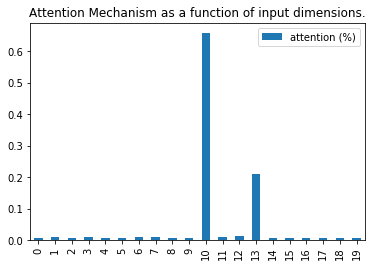

In [9]:
    # plot part.
    import matplotlib.pyplot as plt
    import pandas as pd

    pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar',
                                                                         title='Attention Mechanism as '
                                                                               'a function of input'
                                                                               ' dimensions.')
    plt.show()